# RAG Demo
Note: Code mostly copied from LangChain's tutorial https://python.langchain.com/docs/tutorials/rag/

This tutorial will show you how to implement a simple RAG pipeline.

# Setup

In [1]:
!pip install -qU langchain
!pip install --quiet langchain-google-genai
!pip install -qU langchain-huggingface
!pip install -qU langchain-chroma
!pip install -qU langchain-community
!pip install -qU langgraph
!pip install -qU pypdf
!pip install -q fixthaipdf

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
googletrans 4.0.0rc1 requires httpx==0.13.3, but you have httpx 0.28.1 which is incompatible.

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.4 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.17 which is incompatible.

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update

In [ ]:
import os
# from google.colab import userdata


from dotenv import load_dotenv

load_dotenv()
api_key = os.getenv("GEMINI_API_KEY")
huggingface_api_key = os.getenv("HUGGINGFACE_API_KEY")

# os.environ["GOOGLE_API_KEY"] = userdata.get('gemini_api_key')
os.environ["GOOGLE_API_KEY"] = api_key

In [ ]:
from huggingface_hub import login

# Log in using the access token
login(token=huggingface_api_key)

print("Logged in successfully!")

Logged in successfully!


# Code

## Motivation

In [ ]:
#do no rag first

## Components

In [75]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-001")

In [8]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-m3")

pytorch_model.bin:  12%|#1        | 262M/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [9]:
from langchain_chroma import Chroma

vector_store = Chroma(embedding_function=embeddings)

## Indexing

### Loading documents

We will be using CR99 from Reg Chula as our document. To load this pdf, we will use `PyPDFLoader`.

In [76]:
from langchain_community.document_loaders import PyPDFLoader
from fixthaipdf import clean

file_path = (
    "./content/CR99_2024Th.pdf"
)
loader = PyPDFLoader(file_path)
pages = loader.load_and_split()

pages[0]

Document(metadata={'producer': 'Canva', 'creator': 'Canva', 'creationdate': '2024-08-26T08:56:17+00:00', 'title': 'CR90', 'moddate': '2024-08-28T16:46:33+07:00', 'keywords': 'DAFkkNfTFw0,BAEQi0sFysc', 'author': 'Busaba Cheunjit', 'source': './content/CR99_2024Th.pdf', 'total_pages': 37, 'page': 0, 'page_label': '1'}, page_content='จท 99\n \n คู\x00มือนิสิตเกี่ยวกับงานทะเบียนนิสิต\nป \x00 ก า ร ศ ึ ก ษ า  2567')

In [12]:
for page in pages:
  page.page_content = clean(page.page_content)

In [13]:
print(pages[0])

page_content='จท 99
คู มือนิสิตเกี่ยวกับงานทะเบียนนิสิต
ป   การ ศึก ษา 2567' metadata={'producer': 'Canva', 'creator': 'Canva', 'creationdate': '2024-08-26T08:56:17+00:00', 'title': 'CR90', 'moddate': '2024-08-28T16:46:33+07:00', 'keywords': 'DAFkkNfTFw0,BAEQi0sFysc', 'author': 'Busaba Cheunjit', 'source': './content/CR99_2024Th.pdf', 'total_pages': 37, 'page': 0, 'page_label': '1'}


### Splitting documents

Our loaded document is too long to fit
into the context window of many models. Even for those models that could
fit the full post in their context window, models can struggle to find
information in very long inputs.

To handle this we’ll split the `Document`s into chunks for embedding and
vector storage. This should help us retrieve only the most relevant parts
of the blog post at run time.

We use a
[RecursiveCharacterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/),
which will recursively split the document using common separators like
new lines until each chunk is the appropriate size. This is the
recommended text splitter for generic text use cases.

In [38]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(pages)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 92 sub-documents.


### Storing documents

Now we need to index our 92 text chunks so that we can search over them
at runtime. Our approach is to [embed](https://python.langchain.com/docs/concepts/embedding_models/) the contents of each document split and insert these embeddings
into a [vector store](https://python.langchain.com/docs/concepts/vectorstores/). Given an input query, we can then use
vector search to retrieve relevant documents.

We can embed and store all of our document splits in a single command
using the vector store and embeddings model selected at the [start of the tutorial](https://python.langchain.com/docs/tutorials/rag/#components).

In [39]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['73bdb05e-11c1-40bb-a7af-9f68cb78c473', '534fc9a8-2522-4214-9d39-b3a8bad247ed', '3c7a2b09-b1a0-4c93-a306-552313e1d7c0']


## Retrieval and Generation

Now let’s write the actual application logic. We want to create a simple
application that takes a user question, searches for documents relevant
to that question, passes the retrieved documents and initial question to
a model, and returns an answer.

For generation, we will use the chat model selected at the [start of the tutorial](https://python.langchain.com/docs/tutorials/rag/#components).

We’ll use a prompt for RAG that is checked into the LangChain prompt hub
([here](https://smith.langchain.com/hub/rlm/rag-prompt)).

In [40]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

/Users/idhibhatpankam/Code/courses/NLP-SYS/.venv/lib/python3.12/site-packages/langsmith/client.py:277: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


We'll use [LangGraph](https://langchain-ai.github.io/langgraph/) to tie together the retrieval and generation steps into a single application. This will bring a number of benefits:

- We can define our application logic once and automatically support multiple invocation modes, including streaming, async, and batched calls.
- We get streamlined deployments via [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/).
- LangSmith will automatically trace the steps of our application together.
- We can easily add key features to our application, including [persistence](https://langchain-ai.github.io/langgraph/concepts/persistence/) and [human-in-the-loop approval](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/), with minimal code changes.

To use LangGraph, we need to define three things:

1. The state of our application;
2. The nodes of our application (i.e., application steps);
3. The "control flow" of our application (e.g., the ordering of the steps).

In [41]:
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

### State:

The [state](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of our application controls what data is input to the application, transferred between steps, and output by the application. It is typically a `TypedDict`, but can also be a [Pydantic BaseModel](https://langchain-ai.github.io/langgraph/how-tos/state-model/).

For a simple RAG application, we can just keep track of the input question, retrieved context, and generated answer:

In [51]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

### Nodes (application steps)

Let's start with a simple sequence of two steps: retrieval and generation.

In [77]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

Our retrieval step simply runs a similarity search using the input question, and the generation step formats the retrieved context and original question into a prompt for the chat model.

### Control flow

Finally, we compile our application into a single `graph` object. In this case, we are just connecting the retrieval and generation steps into a single sequence.

In [78]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

LangGraph also comes with built-in utilities for visualizing the control flow of your application:

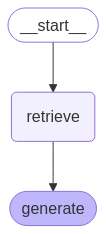

In [79]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Usage

Let's test our application! LangGraph supports multiple invocation modes, including sync, async, and streaming.

Invoke:

In [80]:
question = "บัตรนิสิตหายต้องทำยังไง"

In [82]:
result = graph.invoke({"question": question})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='d195c8bc-c9d7-4bd1-aa24-079d8e64d898', metadata={'author': 'Busaba Cheunjit', 'creationdate': '2024-08-26T08:56:17+00:00', 'creator': 'Canva', 'keywords': 'DAFkkNfTFw0,BAEQi0sFysc', 'moddate': '2024-08-28T16:46:33+07:00', 'page': 10, 'page_label': '11', 'producer': 'Canva', 'source': './content/CR99_2024Th.pdf', 'start_index': 0, 'title': 'CR90', 'total_pages': 37}, page_content='การขอออกบัตรประจำตัวนิสิต (สำหรับนิสิตใหม่ : ใบแรก)\nนิสิตใหม่จะสามารถขอออกบัตรประจำตัวนิสิตได้เมื่อ “ผลการตรวจสอบรูปถ่ายและบัตรประชาชนใน\nการลงทะเบียนแรกเข้าถูกต้องครบถ้วน รวมทั้ง “นิสิตลงทะเบียนแรกเข้าออนไลน์ (เอกสารถูกต้องครบถ้วน)\nลงทะเบียนเรียนและชำระค่าเล่าเรียนเรียบร้อย” (มีสถานภาพเป็นนิสิตโดยสมบูรณ์)\nโดยให้ดำเนินการขอออกบัตรนิสิตที่แอพ CUNEX และต้องมีบัญชีออมทรัพย์ของธนาคารกสิกรไทย\n1. นิสิตกดขอออกบัตรนิสิต ผ่านเมนู “บัตรประจำตัวนิสิต” ใน CUNEX Application\n2. ระบุที่อยู่จัดส่งบน K PLUS หรือเลือกไปรับที่สาขา\n3. รอรับบัตรประจำตัวนิสิตตามที่อยู่จัดส่งหรือที่สาขา\nการขอทำบัตรประจำ

Stream steps:

In [84]:
for step in graph.stream(
    {"question": question}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='d195c8bc-c9d7-4bd1-aa24-079d8e64d898', metadata={'author': 'Busaba Cheunjit', 'creationdate': '2024-08-26T08:56:17+00:00', 'creator': 'Canva', 'keywords': 'DAFkkNfTFw0,BAEQi0sFysc', 'moddate': '2024-08-28T16:46:33+07:00', 'page': 10, 'page_label': '11', 'producer': 'Canva', 'source': './content/CR99_2024Th.pdf', 'start_index': 0, 'title': 'CR90', 'total_pages': 37}, page_content='การขอออกบัตรประจำตัวนิสิต (สำหรับนิสิตใหม่ : ใบแรก)\nนิสิตใหม่จะสามารถขอออกบัตรประจำตัวนิสิตได้เมื่อ “ผลการตรวจสอบรูปถ่ายและบัตรประชาชนใน\nการลงทะเบียนแรกเข้าถูกต้องครบถ้วน รวมทั้ง “นิสิตลงทะเบียนแรกเข้าออนไลน์ (เอกสารถูกต้องครบถ้วน)\nลงทะเบียนเรียนและชำระค่าเล่าเรียนเรียบร้อย” (มีสถานภาพเป็นนิสิตโดยสมบูรณ์)\nโดยให้ดำเนินการขอออกบัตรนิสิตที่แอพ CUNEX และต้องมีบัญชีออมทรัพย์ของธนาคารกสิกรไทย\n1. นิสิตกดขอออกบัตรนิสิต ผ่านเมนู “บัตรประจำตัวนิสิต” ใน CUNEX Application\n2. ระบุที่อยู่จัดส่งบน K PLUS หรือเลือกไปรับที่สาขา\n3. รอรับบัตรประจำตัวนิสิตตามที่อยู่จัดส่งหรือที่สาขา\n

Stream tokens

In [86]:
for message, metadata in graph.stream(
    {"question": question}, stream_mode="messages"
):
    print(message.content, end="|")

หาก|บัตรนิสิตหาย ให้ติดต่อสำนักงานการทะเบียนเพื่อขอทำบัตร|ใหม่ โดยกรอกคำร้องขอทำบัตรประจำตัวนิสิต (จท5|0) และชำระค่าธรรมเนียม 100 บาท หลังจากนั้น ติดต่อขอรับบัตรฯ ที่ธนาคารกสิกรไทย 5| สาขา ได้แก่สาขาจามจุรีสแควร์ สยามสแควร์ โรงพยาบาลจุฬาลงกรณ์ เอ็มบ|ีเคเซ็นเตอร์ และสามย่านมิตรทาวน์ พร้อมแสดงหลักฐาน|

For async invocations, use:

```python
result = await graph.ainvoke(...)
```

and

```python
async for step in graph.astream(...):
```